In [ ]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install pyvista

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 6.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys

homedir = '/content/drive/MyDrive/RA_UBern'

sys.path.append(homedir)
sys.path.append(f'{homedir}/sample_set')

In [ ]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/MyDrive/RA_UBern', '/content/drive/MyDrive/RA_UBern/sample_set']


In [ ]:
import numpy as np
import pandas as pd
import igraph as ig
import pyvista as pv
from scipy.spatial import KDTree
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import measure
import plotly.graph_objects as go
from shapely.geometry import Polygon

print(os.listdir(homedir))

['leptomeningeal_collaterals.pdf', 'ML_analysis_mousebrain.pdf', 'sample_set', '__pycache__', 'sample_set_1x_C57BL6_1_2nd_set_X0_Y0_561_nm_561LP_1x_Both_000000_updated_graph.vtp', 'kdtree_script_cortical_depth.py', '1217_diagrams.gslides', 'notes_start.gdoc', 'Dec24_progress.gslides', 'artery_functions.py', 'notes 0103.gdoc', '1x_C57BL6_3', '1x_C57BL62_2set', 'Balbc2_2set', '0206_new_scan_method.gslides', 'datasets', 'Balb2c_stop_hull_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.csv', 'Balb2c_stop_hull_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.vtp', 'TEST_STOP_R_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.vtp', 'TEST_STOP_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.vtp', 'TEST_STOP_RC_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.vtp', 'TEST_STOP_RC_10_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.vtp', 'WITH_R_stop_hull_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.

In [ ]:
from write_vtp_py3 import write_vtp

In [ ]:
import artery_functions as art

In [ ]:
graph_name = "BL6_1_OV"
# read_igraph_vtp_path = 'WITH_R_stop_hull_full_vec_neigh200_thresh20.0_stop10_spacing4_slice2_nfrac0.25.vtp'
read_igraph_vtp_path = 'BL6_1_OV_fused_depth_NO_deg2_unconnected_line_big_test_full_new_k0.75_neigh5_thresh5.0_spacing1.0_slice0.25_margin50.0.vtp'
# read_csv_path = f'{homedir}/sample_set/06_raster_CONVEXHULL.csv'

mesh = pv.read(f'{homedir}/datasets/{graph_name}/{read_igraph_vtp_path}')

In [ ]:
points = mesh.points
edges = mesh.lines.reshape(-1, 3)[:, 1:]
node_labels = mesh.point_data['node_label']

In [ ]:
points.shape, edges.shape, node_labels.shape

((35965, 3), (41215, 2), (35965,))

In [ ]:
# obtain hull_idcs
hull_idcs = np.arange(len(points))[node_labels == 1]
hull_idcs, len(hull_idcs)

(array([    0,     1,     2, ..., 35961, 35963, 35964]), 11212)

In [ ]:
# slice out points
mask = np.logical_and(points[:,1] >=400, points[:,1] <= 450)
points_slice = points[mask]
inds_slice = np.arange(len(points))[mask]

# retrieve the indices of the hull points within this slice
hull_inds_slice = np.intersect1d(inds_slice, hull_idcs)

In [ ]:
# find the hull points' inds wrt the inds_slice
hull_inds_slice_local = [np.where(inds_slice == val)[0][0] for val in hull_inds_slice]
len(hull_inds_slice_local)

517

517 1917


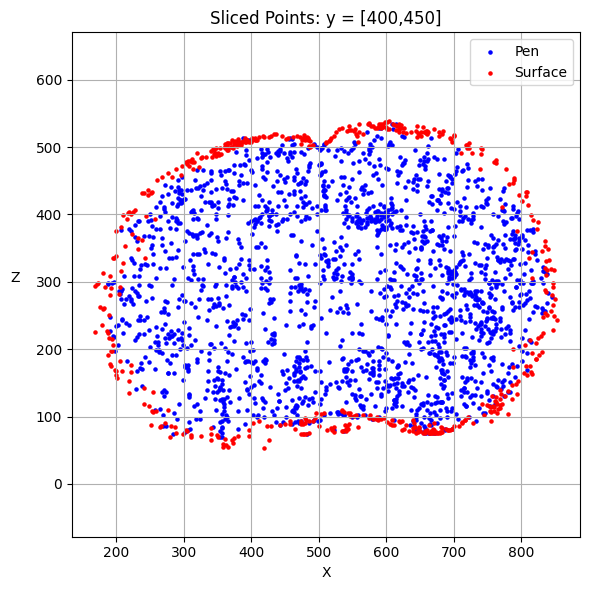

In [ ]:
# plot the sliced points and make the surface nodes a different colour
# Split into two sets
non_hull_inds_local = np.setdiff1d(np.arange(len(points_slice)), hull_inds_slice_local)

points_true = points_slice[hull_inds_slice_local]
points_false = points_slice[non_hull_inds_local]

# inds of points_true maps to hull_inds_slice_local

print(len(points_true), len(points_false))

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(points_false[:, 0], points_false[:, 2], color='blue', label='Pen', s=5)
plt.scatter(points_true[:, 0], points_true[:, 2], color='red', label='Surface', s=5)
plt.legend()
plt.xlabel("X")
plt.ylabel("Z", rotation=0, labelpad=15)
plt.title("Sliced Points: y = [400,450]")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
mask = np.isin(edges[:, 0], hull_inds_slice) & np.isin(edges[:, 1], hull_inds_slice)
selected_edges = edges[mask]

len(selected_edges),selected_edges

(513,
 array([[   38, 14866],
        [   59, 14866],
        [   52, 15082],
        ...,
        [35545, 35615],
        [35615, 35616],
        [35616, 35666]]))

In [ ]:
# we now have a map between hull_inds_slice and ..._local and the edges
for i,val in enumerate(hull_inds_slice):
    inds_edit = np.where(selected_edges==val)
    # print(inds_edit)
    selected_edges[inds_edit] = i

selected_edges_hull = np.copy(selected_edges)

In [ ]:
degs = []
for i in range(len(hull_inds_slice_local)):
    d = np.count_nonzero(selected_edges_hull==i)
    degs.append(d)
    # print(f'idx {i}, location {points_true[i,[0,2]]}, degree {d}')

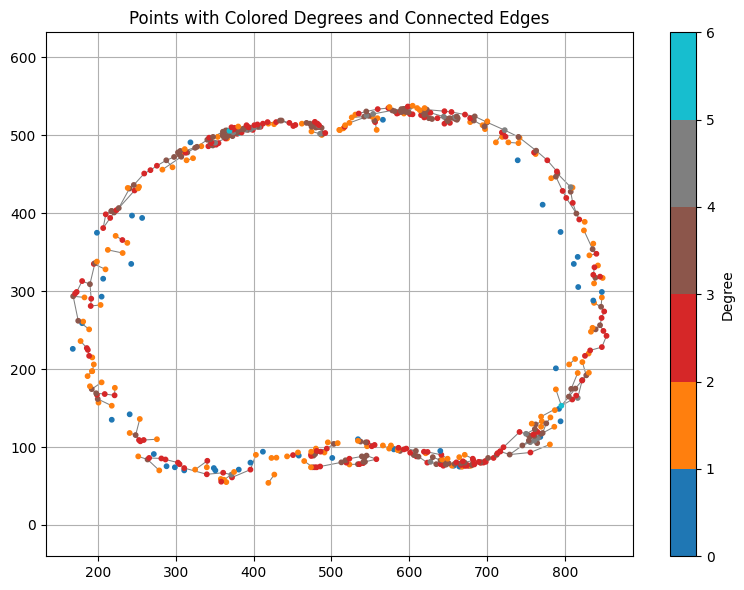

In [ ]:
plt.figure(figsize=(8, 6))

# Step 1: Draw lines for edges
for i, j in selected_edges_hull:
    p1 = points_true[i]
    p2 = points_true[j]
    plt.plot([p1[0], p2[0]], [p1[-1], p2[-1]], color='gray', linewidth=0.75, zorder=1)

from matplotlib.colors import BoundaryNorm

# Define discrete levels
levels = np.arange(min(degs), max(degs) + 1.5)  # +1.5 to include upper bound
cmap = plt.get_cmap('tab10')
norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Use norm in scatter and colorbar
scatter = plt.scatter(
    points_true[:, 0], points_true[:, 2],
    c=degs, cmap=cmap, norm=norm, s=10, zorder=2, alpha=1
)

cbar = plt.colorbar(scatter, ticks=levels, spacing='uniform')
cbar.set_label('Degree')

# plt.colorbar(scatter, label='Degree')
plt.title("Points with Colored Degrees and Connected Edges")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


### Gaussian smoothing, histogram mapping and thresholding/manipulating

In [ ]:
# --- Parameters ---
bin_size = 7.5  # distance per bin (e.g., 1 mm)
# ORIGINAL SIZE 7.5

In [ ]:
# --- Determine bounds and bin edges ---
xmin, ymin = points_slice[hull_inds_slice_local][:,[0,2]].min(axis=0)
xmax, ymax = points_slice[hull_inds_slice_local][:,[0,2]].max(axis=0)

xbins = np.arange(xmin, xmax + bin_size, bin_size)
ybins = np.arange(ymin, ymax + bin_size, bin_size)

# --- Compute heatmap using specified bin size ---
heatmap, xedges, yedges = np.histogram2d(
    points_slice[hull_inds_slice_local, 0], points_slice[hull_inds_slice_local, 2],
    bins=[xbins, ybins]
)

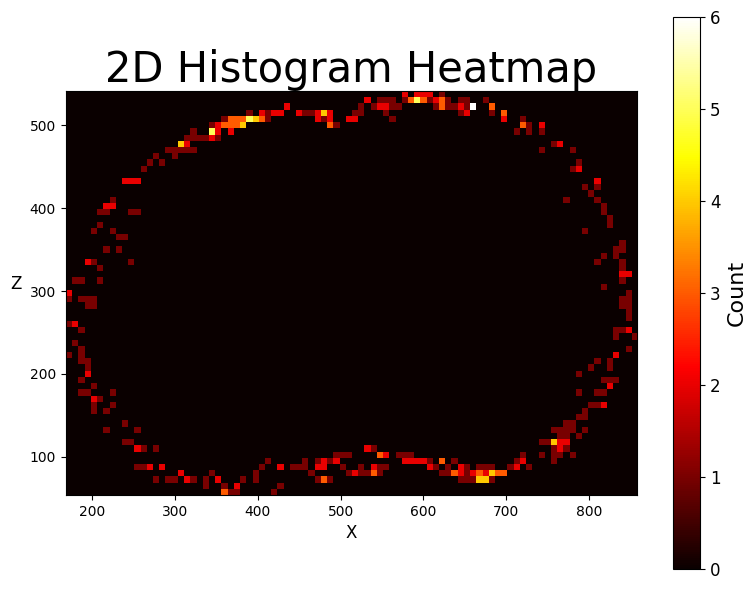

In [ ]:
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap.T,                         # Transpose to match (x, y) orientation
    extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    origin='lower',
    aspect='equal',
    cmap='hot'
)
cbar = plt.colorbar(im)
cbar.set_label('Count', fontsize=16)  # Increase font size here
cbar.ax.tick_params(labelsize=12)  # Adjust tick label font size
plt.xlabel('X', fontsize=12)
plt.ylabel('Z', rotation=0, fontsize=12, labelpad=10)
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])
plt.title('2D Histogram Heatmap', fontsize=30)
# plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# ---- 3. Smooth it with Gaussian filter ----
smoothed = gaussian_filter(heatmap, sigma=2.0)

In [ ]:
smoothed.shape, xbins.shape, ybins.shape

((92, 65), (93,), (66,))

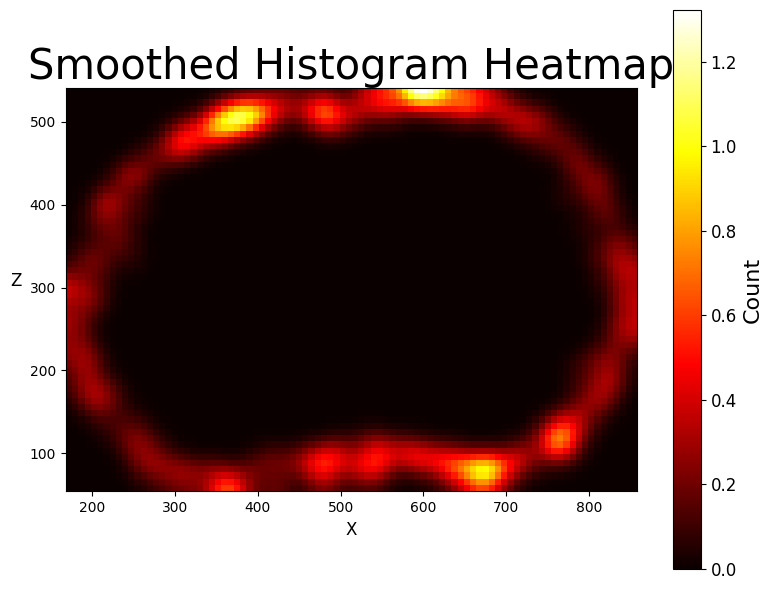

In [ ]:
plt.figure(figsize=(8, 6))
im = plt.imshow(
    smoothed.T,                         # Transpose to match (x, y) orientation
    extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    origin='lower',
    aspect='equal',
    cmap='hot'
)
cbar = plt.colorbar(im)
cbar.set_label('Count', fontsize=16)  # Increase font size here
cbar.ax.tick_params(labelsize=12)  # Adjust tick label font size
plt.xlabel('X', fontsize=12)
plt.ylabel('Z', rotation=0, fontsize=12, labelpad=10)
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])
plt.title('Smoothed Histogram Heatmap', fontsize=30)
# plt.axis('equal')
plt.tight_layout()
plt.show()

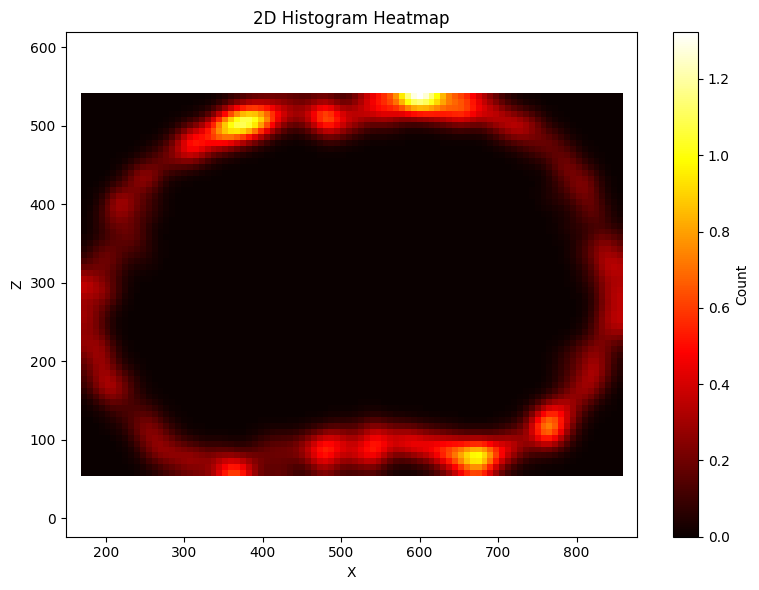

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(
    smoothed.T,                         # Transpose to match (x, y) orientation
    extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    origin='lower',
    aspect='auto',
    cmap='hot'
)
plt.colorbar(label='Count')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('2D Histogram Heatmap')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# --- Plotly interactive heatmap ---
fig = go.Figure(data=go.Heatmap(
    z=smoothed.T,  # transpose for correct orientation
    x=xbins[:-1],
    y=ybins[:-1],
    colorscale='Hot',
    hoverongaps=False,
    colorbar=dict(title="Density")
))
fig.update_layout(
    title="Smoothed Density Heatmap (Hover to Inspect)",
    xaxis_title="X",
    yaxis_title="Y"
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(range=[100, 900])
fig.update_yaxes(range=[0, 600])
fig.show()

In [ ]:
from scipy.ndimage import gaussian_filter, binary_erosion

In [ ]:
from scipy.ndimage import label

Number of white regions: 1


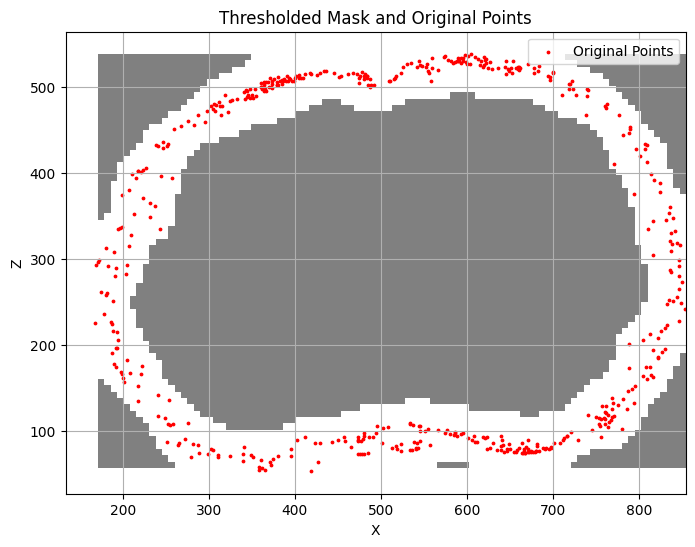

In [ ]:
'''
Just thresholding
'''
# Binary threshold
threshold = 0.05  # adjust as needed
binary_mask = smoothed > threshold

# Erode the mask
eroded_mask = binary_erosion(binary_mask, iterations=2)

# Compute bin centers for plotting image extent
xcenters = (xbins[:-1] + xbins[1:]) / 2
ycenters = (ybins[:-1] + ybins[1:]) / 2

# Assume `binary_mask` is your 2D NumPy array of dtype bool
labeled_mask, num_regions = label(binary_mask)

print("Number of white regions:", num_regions)

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(
    smoothed.T > threshold,  # transpose for correct orientation
    extent=[xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]],
    origin='lower',
    cmap='gray',
    alpha=0.5
)
plt.scatter(points_true[:, 0], points_true[:, 2], s=3, c='red', label='Original Points')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Thresholded Mask and Original Points")
plt.show()

thresh=0.2, num_white= 7
thresh=0.19, num_white= 5
thresh=0.18, num_white= 5
thresh=0.17, num_white= 4
thresh=0.16, num_white= 3
thresh=0.15, num_white= 2
thresh=0.14, num_white= 2
thresh=0.13, num_white= 2
thresh=0.12, num_white= 1


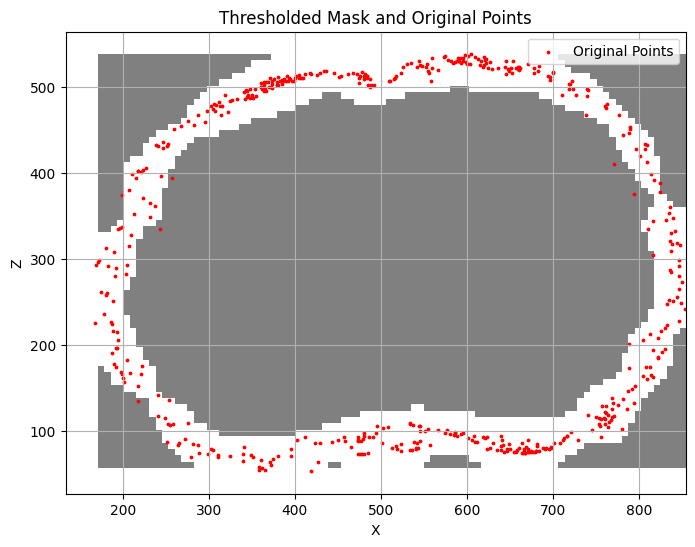

In [ ]:
for i in range(20):
    t = 0.2-i*0.01
    binary_mask = smoothed > t
    labeled_mask, num_regions = label(binary_mask)
    print(f"thresh={np.round(t,2)}, num_white=", num_regions)
    if num_regions == 1:
        break

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(
    smoothed.T > t,  # transpose for correct orientation
    extent=[xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]],
    origin='lower',
    cmap='gray',
    alpha=0.5
)
plt.scatter(points_true[:, 0], points_true[:, 2], s=3, c='red', label='Original Points')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Thresholded Mask and Original Points")
plt.show()

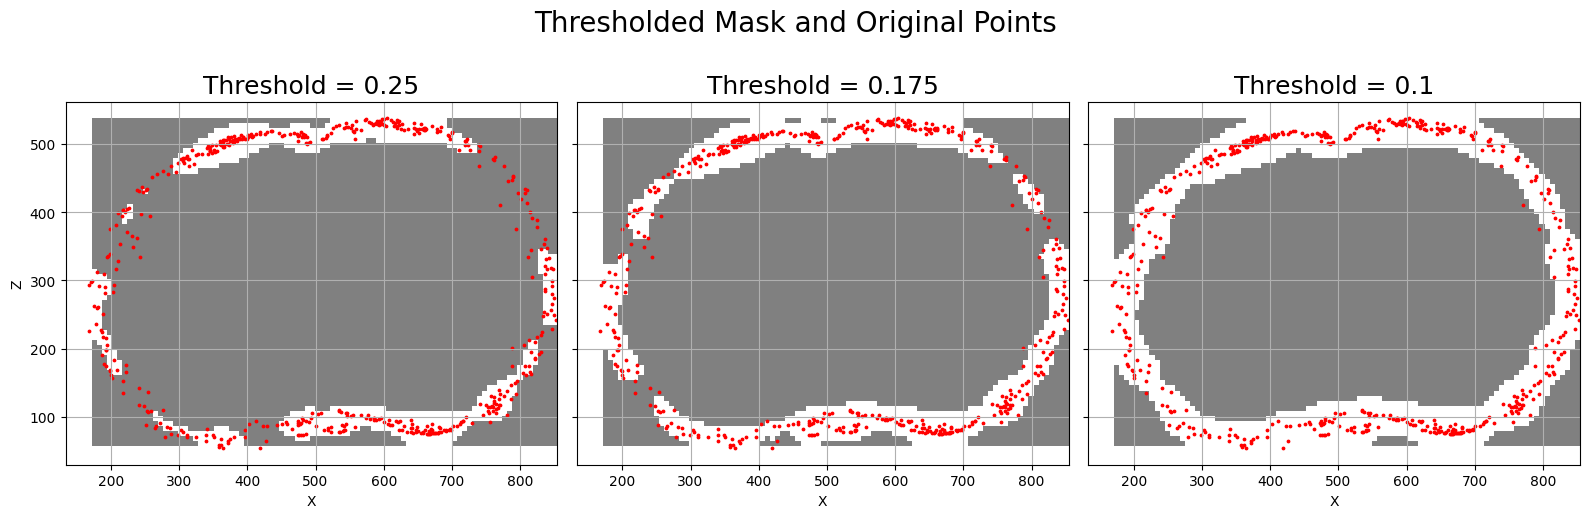

In [ ]:
# Threshold values
thresholds = [0.25, 0.175, 0.1]

# Create subplots
fig, axes = plt.subplots(1, len(thresholds), figsize=(16, 5), sharey=True)

for ax, t in zip(axes, thresholds):
    ax.imshow(
        smoothed.T > t,  # transpose for correct orientation
        extent=[xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]],
        origin='lower',
        cmap='gray',
        alpha=0.5
    )
    ax.scatter(points_true[:, 0], points_true[:, 2], s=3, c='red', label='Original Points')
    ax.set_xlabel('X')
    ax.set_title(f"Threshold = {t}", fontsize=18)
    ax.grid(True)
    # ax.axis('equal')

axes[0].set_ylabel('Z')
# axes[0].legend()
fig.suptitle("Thresholded Mask and Original Points", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

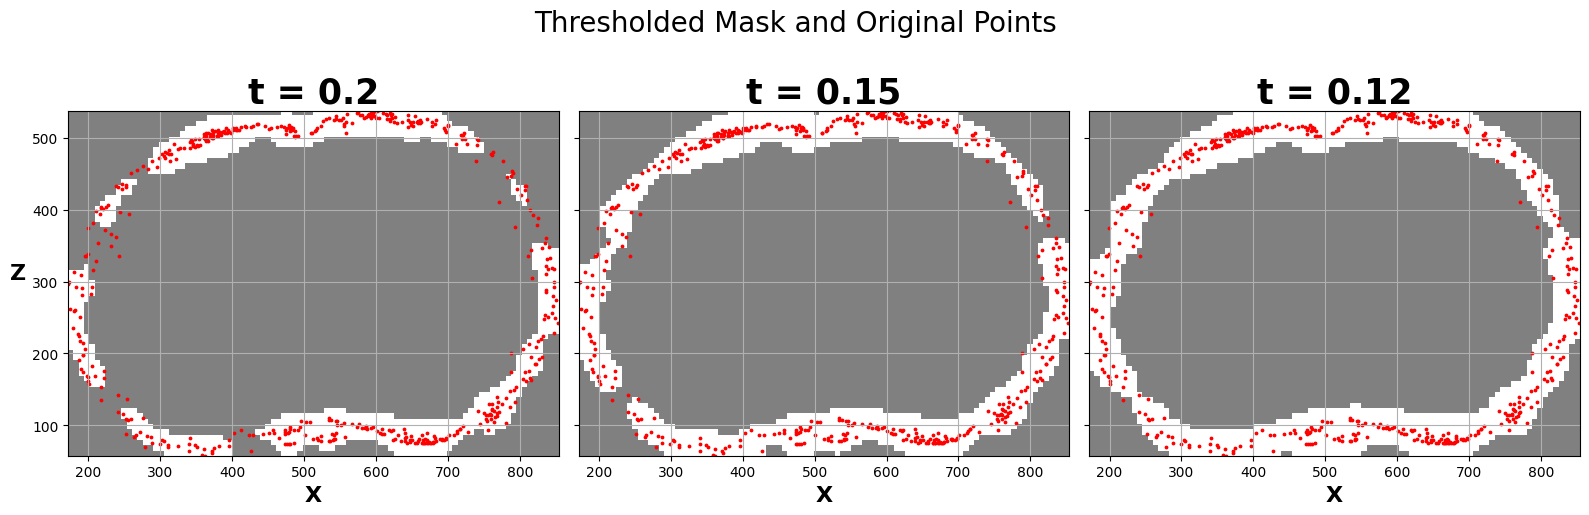

In [ ]:
import matplotlib.pyplot as plt

thresholds = [0.2, 0.15, 0.12]
extent = [xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]]

fig, axes = plt.subplots(1, len(thresholds), figsize=(16, 5), sharey=True)

for ax, t in zip(axes, thresholds):
    ax.imshow(
        smoothed.T > t,
        extent=extent,
        origin='lower',
        cmap='gray',
        alpha=0.5
    )
    ax.scatter(points_true[:, 0], points_true[:, 2], s=3, c='red', label='Original Points')

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])

    ax.set_xlabel('X', fontweight='bold', fontsize=16)
    ax.set_title(f"t = {t}", fontsize=25, fontweight='bold')
    ax.grid(True)
    # ax.axis('equal')  # Optional: comment this out to fill axes more tightly

axes[0].set_ylabel('Z', rotation=0, labelpad=10, fontweight='bold', fontsize=16)
# axes[0].legend()
fig.suptitle("Thresholded Mask and Original Points", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Number of white regions: 2


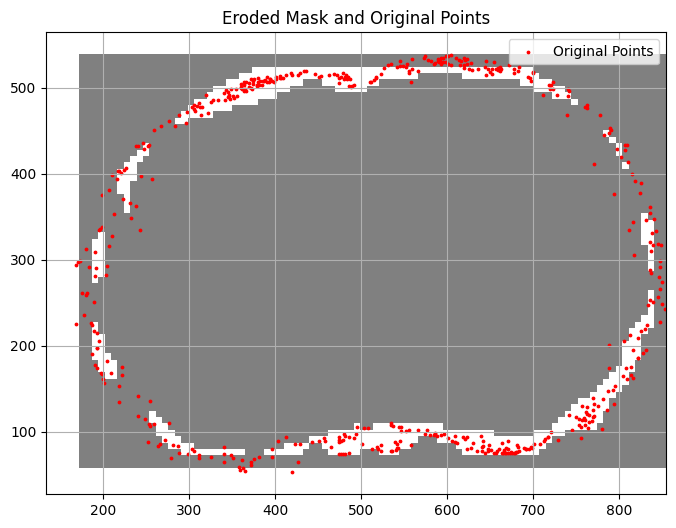

In [ ]:
'''
With erosion
'''
# Binary threshold
threshold = 0.14  # adjust as needed  # original 0.05 for erosion
binary_mask = smoothed > threshold

# Erode the mask
eroded_mask = binary_erosion(binary_mask, iterations=2)

# Compute bin centers for plotting image extent
xcenters = (xbins[:-1] + xbins[1:]) / 2
ycenters = (ybins[:-1] + ybins[1:]) / 2

# Assume `binary_mask` is your 2D NumPy array of dtype bool
labeled_mask, num_regions = label(binary_mask)

print("Number of white regions:", num_regions)

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(
    eroded_mask.T,  # transpose for correct orientation
    extent=[xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]],
    origin='lower',
    cmap='gray',
    alpha=0.5
)
plt.scatter(points_true[:, 0], points_true[:, 2], s=3, c='red', label='Original Points')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Eroded Mask and Original Points")
plt.show()

thresh=0.2, num_white= 7
thresh=0.19, num_white= 5
thresh=0.18, num_white= 5
thresh=0.17, num_white= 4
thresh=0.16, num_white= 3
thresh=0.15, num_white= 2
thresh=0.14, num_white= 2
thresh=0.13, num_white= 2
thresh=0.12, num_white= 1


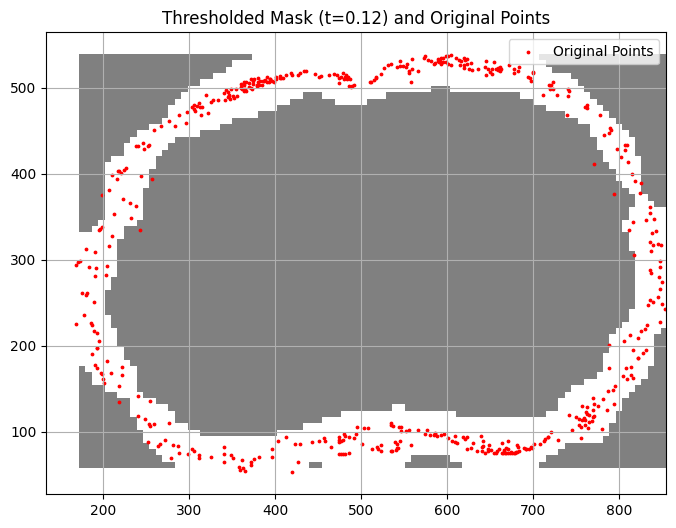

In [ ]:
for i in range(20):
    t = 0.2-i*0.01
    binary_mask = smoothed > t
    # eroded_mask = binary_erosion(binary_mask, iterations=2)
    labeled_mask, num_regions = label(binary_mask)
    print(f"thresh={np.round(t,2)}, num_white=", num_regions)
    if num_regions == 1:
        break

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(
    smoothed.T > t,  # transpose for correct orientation
    extent=[xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]],
    origin='lower',
    cmap='gray',
    alpha=0.5
)
plt.scatter(points_true[:, 0], points_true[:, 2], s=3, c='red', label='Original Points')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title(f"Thresholded Mask (t={np.round(t,2)}) and Original Points")
plt.show()

In [ ]:
threshold = t
smoothed_mask = smoothed > threshold
smoothed_mask = smoothed_mask.T
smoothed_mask.shape

(65, 92)

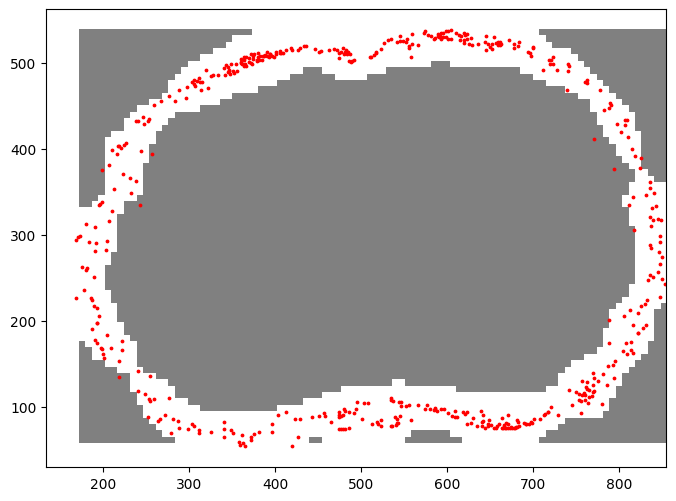

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
plt.imshow(
    smoothed_mask,  # transpose for correct orientation
    extent=[xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]],
    origin='lower',
    cmap='gray',
    alpha=0.5
)
plt.scatter(points_true[:, 0], points_true[:, 2], s=3, c='red', label='Original Points')

In [ ]:
start = (59,56)  # index y first then x
i, j = start
window = smoothed_mask[i-1:i+2, j-1:j+2]

# based on window, determine where to traverse. We desire clockwise traversal
# clockwise:

In [ ]:
smoothed_mask.shape

(65, 92)

In [ ]:
import plotly.express as px

fig = px.imshow(smoothed_mask.astype(int),  # convert bool to int for display
                origin='lower',
                color_continuous_scale='gray')

fig.update_traces(hovertemplate="x: %{x}<br>y: %{y}<br>value: %{z}<extra></extra>")
fig.update_layout(title="Interactive View of smoothed_mask")
fig.show()


In [ ]:
# determine a way to find a starting point
# we know that there's just one white region
# use logic from row scan function

row_start = int(len(smoothed_mask)/2)
# row_start = 40
colvals = smoothed_mask[row_start,:]
diff = np.diff(colvals.astype(int))
inds_departing_mask = np.where(diff==-1)[0][0]

start = (row_start, inds_departing_mask)
start

(32, np.int64(5))

In [ ]:
# determine a way to find a starting point
# we know that there's just one white region
# use logic from row scan function

col_start = int((smoothed_mask.shape[-1])/2)
# row_start = 40
colvals = smoothed_mask[:,col_start]
diff = np.diff(colvals.astype(int))
inds_departing_mask = np.where(diff==-1)[0][0]

start = (inds_departing_mask, col_start)
start

(np.int64(8), 46)

In [ ]:
def trace_boundary(mask, start):
    import numpy as np

    # 8-connected neighbors (clockwise)
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, 1),  (1, 1),  (1, 0),
                 ( 1, -1), (0, -1)]

    # Initialize
    current = start
    boundary = [current]
    visited = set([current])

    # Start with backtrack direction as coming from the left (index 7 in neighbors)
    backtrack_dir = 7
    height, width = mask.shape
    count = 0
    max_steps = 10000  # safety limit

    while True:
        found_next = False

        # Start checking neighbors clockwise from (backtrack_dir + 1) % 8
        for k in range(8):
            ni = (backtrack_dir + 1 + k) % 8
            di, dj = neighbors[ni]
            ni_, nj_ = current[0] + di, current[1] + dj

            if 0 <= ni_ < height and 0 <= nj_ < width and mask[ni_, nj_]:
                next_pixel = (ni_, nj_)
                if next_pixel == start and len(boundary) > 5:
                    return boundary
                if next_pixel not in visited:
                    boundary.append(next_pixel)
                    visited.add(next_pixel)
                    current = next_pixel
                    backtrack_dir = (ni + 4) % 8  # reverse direction
                    found_next = True
                    break

        if not found_next:
            break  # no connected neighbor found — possibly an open boundary

        count += 1
        if count > max_steps:
            print("Warning: max steps reached")
            break

    return boundary


In [ ]:
boundary_points = trace_boundary(smoothed_mask, start)

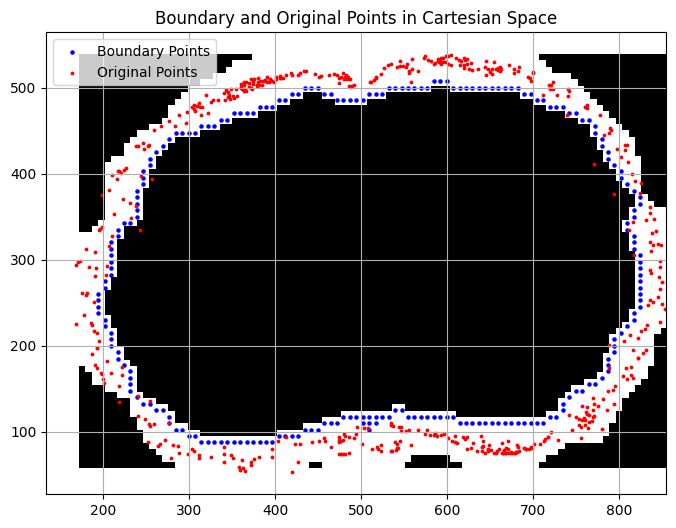

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute bin centers for mapping
xcenters = (xbins[:-1] + xbins[1:]) / 2
ycenters = (ybins[:-1] + ybins[1:]) / 2

# Convert boundary_points (row, col) → (x, y)
boundary_xy = np.array([
    [xcenters[col], ycenters[row]] for row, col in boundary_points
])

# Plot in Cartesian space
plt.figure(figsize=(8, 6))
plt.imshow(
    smoothed_mask, origin='lower', cmap='gray',
    extent=[xcenters[0], xcenters[-1], ycenters[0], ycenters[-1]]
)
plt.scatter(boundary_xy[:, 0], boundary_xy[:, 1], c='blue', s=5, label='Boundary Points')
plt.scatter(points_true[:, 0], points_true[:, 2], c='red', s=3, label='Original Points')
plt.title("Boundary and Original Points in Cartesian Space")
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


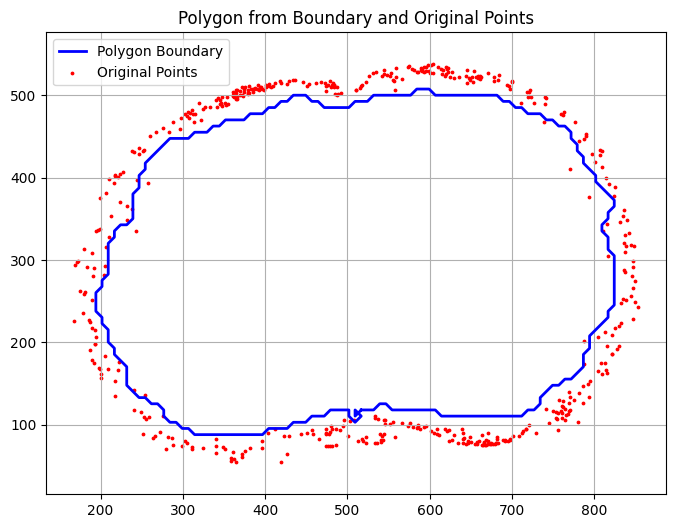

In [ ]:
from shapely.geometry import Polygon
# import matplotlib.pyplot as plt

# Step 1: Create the polygon
polygon = Polygon(boundary_xy)

# Step 2: Plot the polygon and the points
plt.figure(figsize=(8, 6))

# Plot polygon boundary
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly, y_poly, color='blue', linewidth=2, label='Polygon Boundary')

# Plot original points
plt.scatter(points_true[:, 0], points_true[:, 2], c='red', s=3, label='Original Points')

plt.title("Polygon from Boundary and Original Points")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from shapely.geometry import Point
import numpy as np

# Define shrink values to test (in your units, e.g., mm or pixels)
shrink_values = np.linspace(-30, -10, 50)  # test 50 values from 0 to 5

best_r = None
min_total_dist = float('inf')
distances_record = []

for r in shrink_values:
    # Shrink the polygon
    shrunk_poly = polygon.buffer(-r)

    # Skip if the polygon is invalid or disappears
    if shrunk_poly.is_empty or not shrunk_poly.is_valid:
        distances_record.append(np.nan)
        continue

    # Compute total distance from each point to polygon boundary
    total_dist = sum(shrunk_poly.exterior.distance(Point(p)) for p in points_true[:,[0,2]])
    distances_record.append(total_dist)

    # Update best if this is the smallest so far
    if total_dist < min_total_dist:
        min_total_dist = total_dist
        best_r = r

# Now you have best_r and a record of all distances
print(f"Best shrink value (r): {best_r:.3f} with total distance: {min_total_dist:.3f}")


Best shrink value (r): -21.837 with total distance: 3571.957


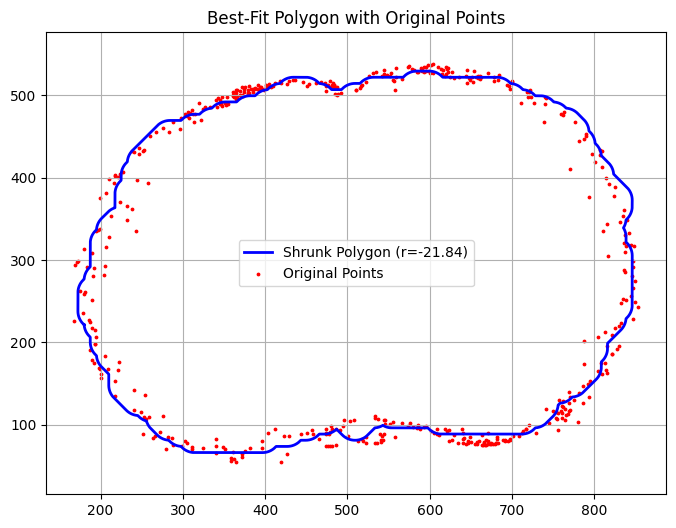

In [ ]:
# Step 1: Create the best-fit polygon
best_polygon = polygon.buffer(-best_r)

# Step 2: Plot it with points_true
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot the best-fit polygon
x_best, y_best = best_polygon.exterior.xy
plt.plot(x_best, y_best, color='blue', linewidth=2, label=f'Shrunk Polygon (r={best_r:.2f})')

# Plot the original points
plt.scatter(points_true[:, 0], points_true[:, 2], c='red', s=3, label='Original Points')
plt.xlabel('X')
plt.ylabel('Z')

plt.title("Best-Fit Polygon with Original Points")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
best_polygon = polygon.buffer(-best_r)

# Step 1: Build customdata for all points (Index, Degree, X, Z)
indices = np.arange(len(points_true))
customdata_all = np.column_stack((indices, degs, points_true[:, 0], points_true[:, 2]))

# Step 2: Identify special points (inside polygon & deg ≤ 1)
mask_special = np.array([
    best_polygon.contains(Point(pt[[0, 2]])) and degs[i] <= 1
    for i, pt in enumerate(points_true)
])
special_points = points_true[mask_special]
customdata_special = customdata_all[mask_special]

# Step 3: Create the figure
fig = go.Figure()

# Polygon boundary
x_poly, y_poly = map(np.array, best_polygon.exterior.xy)
fig.add_trace(go.Scatter(
    x=x_poly,
    y=y_poly,
    mode='lines',
    line=dict(color='blue', width=2),
    name=f'Polygon (r={best_r:.2f})'
))

# Connection lines
for i, j in selected_edges_hull:
    p1 = points_true[i, [0, 2]]
    p2 = points_true[j, [0, 2]]
    fig.add_trace(go.Scatter(
        x=[p1[0], p2[0]],
        y=[p1[1], p2[1]],
        mode='lines',
        line=dict(color='gray', width=1),
        showlegend=False
    ))

# All points
fig.add_trace(go.Scatter(
    x=points_true[:, 0],
    y=points_true[:, 2],
    mode='markers',
    marker=dict(color='black', size=3),
    name='All Points',
    customdata=customdata_all,
    hovertemplate=(
        "Index: %{customdata[0]}<br>"
        "Degree: %{customdata[1]}<br>"
        "X: %{customdata[2]:.2f}<br>"
        "Z: %{customdata[3]:.2f}<extra></extra>"
    )
))

# Special red points
fig.add_trace(go.Scatter(
    x=special_points[:, 0],
    y=special_points[:, 2],
    mode='markers',
    marker=dict(color='red', size=6),
    name='Inside Polygon & deg ≤ 1',
    customdata=customdata_special,
    hovertemplate=(
        "Index: %{customdata[0]}<br>"
        "Degree: %{customdata[1]}<br>"
        "X: %{customdata[2]:.2f}<br>"
        "Z: %{customdata[3]:.2f}<extra></extra>"
    )
))

# Final layout
fig.update_layout(
    title="All Points with Index, Degree, Location & Polygon",
    xaxis_title="X",
    yaxis_title="Z",
    showlegend=True,
    yaxis_scaleanchor="x",
    template="simple_white"
)

fig.show()


In [ ]:
'''
Here's the strategy:
- find the vector going from a node to the polygon
- if degree is 1, find the vector connecting the node to another surface node
--- do dot product and find the angle. Test different angle values for threshold. If angle<threshold then
- if degree is 0, use distance threshold directly

This functions expects points in 2 coords, not the complete point!!
'''

def determine_removal(point_id, points, deg, edges, best_polygon, angle_threshold=30, distance_threshold=15):

    print(f'deg = {deg}')
    point = points[point_id,[0,2]]
    point_coords = Point(point)
    print(f'point = {point}')

    if deg == 0:
        print('deg is 0')
        distance = best_polygon.exterior.distance(point_coords)
        if distance < distance_threshold:
            return True
        else:
            return False

    elif deg == 1:
        print('deg is 1')
        nearest_point = best_polygon.exterior.interpolate(best_polygon.exterior.project(point_coords))
        print(f'found nearest point: {nearest_point}')
        direction_vector = np.array(nearest_point.coords[0]) - point
        print('found direction vector')

        where_connect = np.where(edges==point_id)
        print(f'where connect: {where_connect}')
        if where_connect[1][0] == 0:
            point_neigh_id = edges[where_connect[0][0], 1]
        else:
            point_neigh_id = edges[where_connect[0][0], 0]

        print(f'point_neigh_id: {point_neigh_id}')

        edge_direction_vector = points[point_id,[0,2]] - points[point_neigh_id,[0,2]]

        v1 = direction_vector / np.linalg.norm(direction_vector)
        v2 = edge_direction_vector / np.linalg.norm(edge_direction_vector)

        # Compute angle in radians
        angle_rad = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

        # Convert to degrees and shift to [0, 90]
        angle_deg = np.degrees(angle_rad)
        angle_deg = min(angle_deg, 180 - angle_deg)

        print(f'angle: {angle_deg}')
        if angle_deg < angle_threshold:
            return True
        else:
            return False

In [ ]:
'''
Here's the strategy:
- find the vector going from a node to the polygon
- if degree is 1, find the vector connecting the node to another surface node
--- do dot product and find the angle. Test different angle values for threshold. If angle<threshold then
- if degree is 0, use distance threshold directly

This functions expects points in 2 coords, not the complete point!!
'''

def determine_removal(point_id, points, deg, edges, best_polygon, angle_threshold=30, distance_threshold=15):

    # print(f'deg = {deg}')
    point = points[point_id,[0,2]]
    point_coords = Point(point)
    distance = best_polygon.exterior.distance(point_coords)
    # print(f'point = {point}')

    if distance > distance_threshold:
        return True
    else:
        return False

    if deg == 1 and distance > distance_threshold:
        # print('deg is 1')
        nearest_point = best_polygon.exterior.interpolate(best_polygon.exterior.project(point_coords))
        # print(f'found nearest point: {nearest_point}')
        direction_vector = np.array(nearest_point.coords[0]) - point
        # print('found direction vector')

        where_connect = np.where(edges==point_id)
        # print(f'where connect: {where_connect}')
        if where_connect[1][0] == 0:
            point_neigh_id = edges[where_connect[0][0], 1]
        else:
            point_neigh_id = edges[where_connect[0][0], 0]

        # print(f'point_neigh_id: {point_neigh_id}')

        edge_direction_vector = points[point_id,[0,2]] - points[point_neigh_id,[0,2]]

        v1 = direction_vector / np.linalg.norm(direction_vector)
        v2 = edge_direction_vector / np.linalg.norm(edge_direction_vector)

        # Compute angle in radians
        angle_rad = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

        # Convert to degrees and shift to [0, 90]
        angle_deg = np.degrees(angle_rad)
        angle_deg = min(angle_deg, 180 - angle_deg)

        # print(f'angle: {angle_deg}')
        if angle_deg < angle_threshold:
            return True
        else:
            return False

In [ ]:
determine_removal(33, points_true, degs[33], selected_edges, best_polygon, angle_threshold=30, distance_threshold=15)

True

In [ ]:
best_polygon = polygon.buffer(-best_r)

# Step 1: Build customdata for all points (Index, Degree, X, Z)
indices = np.arange(len(points_true))


distances = np.array([
    best_polygon.exterior.distance(Point(pt[[0, 2]]))
    for pt in points_true
])
customdata_all = np.column_stack((indices, degs, points_true[:, 0], points_true[:, 2], distances))
# customdata_special = customdata_all[mask_special]

# Step 2: Identify special points (inside polygon & deg ≤ 1)
mask_special = np.array([
    best_polygon.contains(Point(pt[[0, 2]])) and degs[i] <= 1
    for i, pt in enumerate(points_true)
])
special_points = points_true[mask_special]
print(len(special_points))
customdata_special = customdata_all[mask_special]

# Step 3: Create the figure
fig = go.Figure()

# Polygon boundary
x_poly, y_poly = map(np.array, best_polygon.exterior.xy)
fig.add_trace(go.Scatter(
    x=x_poly,
    y=y_poly,
    mode='lines',
    line=dict(color='blue', width=2),
    name=f'Polygon (r={best_r:.2f})'
))

# Connection lines
for i, j in selected_edges_hull:
    p1 = points_true[i, [0, 2]]
    p2 = points_true[j, [0, 2]]
    fig.add_trace(go.Scatter(
        x=[p1[0], p2[0]],
        y=[p1[1], p2[1]],
        mode='lines',
        line=dict(color='gray', width=1),
        showlegend=False
    ))

# All points
fig.add_trace(go.Scatter(
    x=points_true[:, 0],
    y=points_true[:, 2],
    mode='markers',
    marker=dict(color='black', size=3),
    name='All Points',
    customdata=customdata_all,
    hovertemplate=(
    "Index: %{customdata[0]}<br>"
    "Degree: %{customdata[1]}<br>"
    "X: %{customdata[2]:.2f}<br>"
    "Z: %{customdata[3]:.2f}<br>"
    "Dist to Polygon: %{customdata[4]:.2f} µm<extra></extra>"
)
))

# Special red points
fig.add_trace(go.Scatter(
    x=special_points[:, 0],
    y=special_points[:, 2],
    mode='markers',
    marker=dict(color='red', size=6),
    name='Inside Polygon & deg ≤ 1',
    customdata=customdata_special,
    hovertemplate=(
    "Index: %{customdata[0]}<br>"
    "Degree: %{customdata[1]}<br>"
    "X: %{customdata[2]:.2f}<br>"
    "Z: %{customdata[3]:.2f}<br>"
    "Dist to Polygon: %{customdata[4]:.2f} µm<extra></extra>"
)
))

# Final layout
fig.update_layout(
    title="All Points with Index, Degree, Location & Polygon",
    xaxis_title="X",
    yaxis_title="Z",
    showlegend=True,
    yaxis_scaleanchor="x",
    template="simple_white"
)

fig.show()


122


In [ ]:
points_true_original = np.copy(points_true)
points_false_original = np.copy(points_false)
hull_inds_slice_local_original = np.copy(hull_inds_slice_local)
polygon_ = polygon

In [ ]:
points_true_original[33]

array([788., 401., 174.])

In [ ]:
points_true_original.shape, points_false_original.shape, hull_inds_slice_local_original.shape

((517, 3), (1917, 3), (517,))

In [ ]:
hull_inds_slice_local_original[33]

np.int64(226)

In [ ]:
points_true = np.copy(points_true_original)
points_false = np.copy(points_false_original)
hull_inds_slice_local = np.copy(hull_inds_slice_local_original)

In [ ]:
np.linspace(30,20, num=11)

array([30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20.])

In [ ]:
'''
To apply the function:
- let's do a while loop with 10 iterations
- the points going as input must be inside the polygon and have degree<=1
- after each loop, we update edges, points_true,
- use these to regenerate the polygon and find a new best_r value

while condition: either no removal candidates or count should be high

'''
combo = [0,2]
threshold_d = np.linspace(30,20, num=10)
count = 0
no_removal = False
all_removals = []

for iter,threshold in enumerate(threshold_d):

    print(f'Iteration number {iter+1}')

    count += 1

    # do histogram, smoothing and binary mask
    # --- Parameters ---
    bin_size = 7.5  # distance per bin (e.g., 1 mm)
    # ORIGINAL SIZE 7.5

    # --- Determine bounds and bin edges ---
    xmin, ymin = points_slice[hull_inds_slice_local][:,combo].min(axis=0)
    xmax, ymax = points_slice[hull_inds_slice_local][:,combo].max(axis=0)

    xbins = np.arange(xmin, xmax + bin_size, bin_size)
    ybins = np.arange(ymin, ymax + bin_size, bin_size)

    # --- Compute heatmap using specified bin size ---
    heatmap, xedges, yedges = np.histogram2d(
        points_slice[hull_inds_slice_local, combo[0]], points_slice[hull_inds_slice_local, combo[1]],
        bins=[xbins, ybins]
    )

    smoothed = gaussian_filter(heatmap, sigma=2.0)

    # Binary threshold
    for i in range(20):
        t = 0.2-i*0.01
        binary_mask = smoothed > t
        # eroded_mask = binary_erosion(binary_mask, iterations=2)
        labeled_mask, num_regions = label(binary_mask)
        # print(f"thresh={np.round(t,2)}, num_white=", num_regions)
        if num_regions == 1:
            break

    smoothed_mask = smoothed > t
    # get the polygon with Moore neighbour tracing
    smoothed_mask = smoothed_mask.T

    row_start = int(len(smoothed_mask)/2)
    colvals = smoothed_mask[row_start,:]
    diff = np.diff(colvals.astype(int))
    inds_departing_mask = np.where(diff==-1)[0][0]
    start = (row_start, inds_departing_mask)

    boundary_points_ = trace_boundary(smoothed_mask, start)
    boundary_xy_ = np.array([[xcenters[col], ycenters[row]] for row, col in boundary_points])
    polygon_ = Polygon(boundary_xy_)

    shrink_values = np.linspace(-30, -10, 50)  # test 50 values from 0 to 5

    best_r = None
    min_total_dist = float('inf')
    distances_record = []

    for r in shrink_values:
        # Shrink the polygon
        shrunk_poly = polygon_.buffer(-r)

        # Skip if the polygon is invalid or disappears
        if shrunk_poly.is_empty or not shrunk_poly.is_valid:
            distances_record.append(np.nan)
            continue

        # Compute total distance from each point to polygon boundary
        total_dist = sum(shrunk_poly.exterior.distance(Point(p)) for p in points_true[:,[combo[0],combo[1]]])
        distances_record.append(total_dist)

        # Update best if this is the smallest so far
        if total_dist < min_total_dist:
            min_total_dist = total_dist
            best_r = r

    best_polygon_ = polygon_.buffer(-best_r)

    # start with binary map, polygon and points
    mask_special = np.array([
    best_polygon_.contains(Point(pt[[combo[0], combo[1]]])) and degs[i] <= 1
        for i, pt in enumerate(points_true)
                            ])
    special_points = points_true[mask_special]
    local_inds = np.arange(len(points_true))[mask_special]
    print(f'len of local special points: {len(local_inds)}')

    # break

    # select removal candidates: degree<=1 and distance
    # run determine_removal for each of the candidates: obtain an array with all the candidate IDs wrt local hull ID
    removals = []
    for point_id in local_inds:
        # print(point_id)
        ans = determine_removal(point_id, points_true, degs[point_id], selected_edges, best_polygon_, distance_threshold=20)
        if ans:
            removals.append(point_id)
            # print(point_id)

    print(f'len of removals: {len(removals)}')
    if len(removals) == 0:
        print(f'No more nodes to remove! iterations completed={iter}')
        continue

    # break
    # rewrite points_true and points_false and update hull_inds_slice_local
    # removals = np.array(removals)
    removals = hull_inds_slice_local[removals]
    for r in removals:
        all_removals.append(r)

    hull_inds_slice_local = np.setdiff1d(hull_inds_slice_local, removals, assume_unique=True)
    print(f'hull_inds left: {len(hull_inds_slice_local)}')
    non_hull_inds_local = np.setdiff1d(np.arange(len(points_slice)), hull_inds_slice_local)
    points_true = points_slice[hull_inds_slice_local]
    points_false = points_slice[non_hull_inds_local]

    print('')

all_removals = np.unique(np.array(all_removals))

Iteration number 1
len of local special points: 122
len of removals: 17
hull_inds left: 500

Iteration number 2
len of local special points: 95
len of removals: 2
hull_inds left: 498

Iteration number 3
len of local special points: 89
len of removals: 0
No more nodes to remove! iterations completed=2
Iteration number 4
len of local special points: 89
len of removals: 0
No more nodes to remove! iterations completed=3
Iteration number 5
len of local special points: 89
len of removals: 0
No more nodes to remove! iterations completed=4
Iteration number 6
len of local special points: 89
len of removals: 0
No more nodes to remove! iterations completed=5
Iteration number 7
len of local special points: 89
len of removals: 0
No more nodes to remove! iterations completed=6
Iteration number 8
len of local special points: 89
len of removals: 0
No more nodes to remove! iterations completed=7
Iteration number 9
len of local special points: 89
len of removals: 0
No more nodes to remove! iterations co

In [ ]:
len(hull_inds_slice_local), len(hull_inds_slice_local_original)

(498, 517)

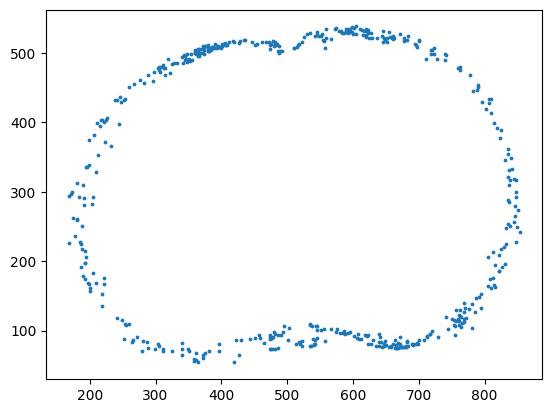

In [ ]:
plt.scatter(points_slice[hull_inds_slice_local,0], points_slice[hull_inds_slice_local,2], s=3)

In [ ]:
points_true.shape, points_true_original.shape

((498, 3), (517, 3))

In [ ]:
all_removals

array([  21,   62,  128,  147,  226,  299,  608,  664,  666,  683,  699,
        756,  798,  831,  980, 1206, 1255, 1777, 1897])

In [ ]:
import plotly.graph_objects as go
from shapely.geometry import Point

# Final polygon outline
x_poly, y_poly = map(np.array, best_polygon_.exterior.xy)

# Removed points (convert to 2D X,Z)
removed_points = points_slice[all_removals]
removed_custom = np.column_stack((
    all_removals,
    removed_points[:, 0],
    removed_points[:, 2]
))

# Final valid surface points
valid_points = points_true
valid_custom = np.column_stack((
    hull_inds_slice_local,
    valid_points[:, 0],
    valid_points[:, 2]
))

# Create plot
fig = go.Figure()

# Polygon outline
fig.add_trace(go.Scatter(
    x=x_poly, y=y_poly,
    mode='lines',
    line=dict(color='blue', width=2),
    name='Final Polygon'
))

# Remaining points
fig.add_trace(go.Scatter(
    x=valid_points[:, 0],
    y=valid_points[:, 2],
    mode='markers',
    marker=dict(color='black', size=3),
    name='Final Surface Points',
    customdata=valid_custom,
    hovertemplate=(
        "Index: %{customdata[0]}<br>X: %{customdata[1]:.2f}<br>Z: %{customdata[2]:.2f}<extra></extra>"
    )
))

# Removed points
fig.add_trace(go.Scatter(
    x=removed_points[:, 0],
    y=removed_points[:, 2],
    mode='markers',
    marker=dict(color='red', size=6),
    name='Removed Points',
    customdata=removed_custom,
    hovertemplate=(
        "REMOVED<br>Index: %{customdata[0]}<br>X: %{customdata[1]:.2f}<br>Z: %{customdata[2]:.2f}<extra></extra>"
    )
))

fig.update_layout(
    title='Surface Point Cleanup: Final Polygon and Removed Points',
    xaxis_title='X',
    yaxis_title='Z',
    showlegend=True,
    yaxis_scaleanchor="x",
    template='simple_white'
)

fig.show()


In [ ]:
import plotly.graph_objects as go
from shapely.geometry import Point
import numpy as np

# Final polygon outline
x_poly, y_poly = map(np.array, best_polygon_.exterior.xy)

# Compute distance to polygon for all points
all_points = points_slice
all_distances = np.array([
    best_polygon_.exterior.distance(Point(p[[0, 2]])) for p in all_points
])

# Prepare data for valid and removed points
valid_points = points_slice[hull_inds_slice_local]
removed_points = points_slice[all_removals]

valid_indices = hull_inds_slice_local
removed_indices = all_removals

valid_custom = np.column_stack((
    valid_indices,
    valid_points[:, 0],
    valid_points[:, 2],
    all_distances[valid_indices]
))

removed_custom = np.column_stack((
    removed_indices,
    removed_points[:, 0],
    removed_points[:, 2],
    all_distances[removed_indices]
))

# Create plot
fig = go.Figure()

# Polygon outline
fig.add_trace(go.Scatter(
    x=x_poly, y=y_poly,
    mode='lines',
    line=dict(color='blue', width=2),
    name='Final Polygon'
))

# Edges (use selected_edges_hull)
for i, j in selected_edges_hull:
    pi = points_true_original[i, [0, 2]]
    pj = points_true_original[j, [0, 2]]
    fig.add_trace(go.Scatter(
        x=[pi[0], pj[0]],
        y=[pi[1], pj[1]],
        mode='lines',
        line=dict(color='gray', width=1),
        showlegend=False
    ))

# Valid points
fig.add_trace(go.Scatter(
    x=valid_points[:, 0],
    y=valid_points[:, 2],
    mode='markers',
    marker=dict(color='black', size=3),
    name='Final Surface Points',
    customdata=valid_custom,
    hovertemplate=(
        "Index: %{customdata[0]}<br>"
        "X: %{customdata[1]:.2f}<br>"
        "Z: %{customdata[2]:.2f}<br>"
        "Dist to Polygon: %{customdata[3]:.2f} µm<extra></extra>"
    )
))

# Removed points
fig.add_trace(go.Scatter(
    x=removed_points[:, 0],
    y=removed_points[:, 2],
    mode='markers',
    marker=dict(color='red', size=6),
    name='Removed Points',
    customdata=removed_custom,
    hovertemplate=(
        "REMOVED<br>"
        "Index: %{customdata[0]}<br>"
        "X: %{customdata[1]:.2f}<br>"
        "Z: %{customdata[2]:.2f}<br>"
        "Dist to Polygon: %{customdata[3]:.2f} µm<extra></extra>"
    )
))

# Layout
fig.update_layout(
    title='Final Cleanup with Polygon, Edges & Removal Distance',
    xaxis_title='X',
    yaxis_title='Z',
    showlegend=True,
    yaxis_scaleanchor="x",
    template='simple_white'
)

fig.show()


In [ ]:
'''
To apply the function:
- let's do a while loop with 10 iterations
- the points going as input must be inside the polygon and have degree<=1
- after each loop, we update edges, points_true,
- use these to regenerate the polygon and find a new best_r value

while condition: either no removal candidates or count should be high

'''
combo = [0,2]
threshold_d = np.linspace(30,20, num=10)
count = 0
no_removal = False
all_removals = []
original_removals = []

for iter,threshold in enumerate(threshold_d):

    print(f'Iteration number {iter+1}')

    count += 1

    # do histogram, smoothing and binary mask
    # --- Parameters ---
    bin_size = 7.5  # distance per bin (e.g., 1 mm)
    # ORIGINAL SIZE 7.5

    # --- Determine bounds and bin edges ---
    xmin, ymin = points_slice[hull_inds_slice_local][:,combo].min(axis=0)
    xmax, ymax = points_slice[hull_inds_slice_local][:,combo].max(axis=0)

    xbins = np.arange(xmin, xmax + bin_size, bin_size)
    ybins = np.arange(ymin, ymax + bin_size, bin_size)

    # --- Compute heatmap using specified bin size ---
    heatmap, xedges, yedges = np.histogram2d(
        points_slice[hull_inds_slice_local, combo[0]], points_slice[hull_inds_slice_local, combo[1]],
        bins=[xbins, ybins]
    )

    smoothed = gaussian_filter(heatmap, sigma=2.0)

    # Binary threshold
    for i in range(20):
        t = 0.2-i*0.01
        binary_mask = smoothed > t
        # eroded_mask = binary_erosion(binary_mask, iterations=2)
        labeled_mask, num_regions = label(binary_mask)
        # print(f"thresh={np.round(t,2)}, num_white=", num_regions)
        if num_regions == 1:
            break

    smoothed_mask = smoothed > t
    # get the polygon with Moore neighbour tracing
    smoothed_mask = smoothed_mask.T

    row_start = int(len(smoothed_mask)/2)
    colvals = smoothed_mask[row_start,:]
    diff = np.diff(colvals.astype(int))
    inds_departing_mask = np.where(diff==-1)[0][0]
    start = (row_start, inds_departing_mask)

    boundary_points_ = trace_boundary(smoothed_mask, start)
    boundary_xy_ = np.array([[xcenters[col], ycenters[row]] for row, col in boundary_points])
    polygon_ = Polygon(boundary_xy_)

    shrink_values = np.linspace(-30, -10, 50)  # test 50 values from 0 to 5

    best_r = None
    min_total_dist = float('inf')
    distances_record = []

    for r in shrink_values:
        # Shrink the polygon
        shrunk_poly = polygon_.buffer(-r)

        # Skip if the polygon is invalid or disappears
        if shrunk_poly.is_empty or not shrunk_poly.is_valid:
            distances_record.append(np.nan)
            continue

        # Compute total distance from each point to polygon boundary
        total_dist = sum(shrunk_poly.exterior.distance(Point(p)) for p in points_true[:,[combo[0],combo[1]]])
        distances_record.append(total_dist)

        # Update best if this is the smallest so far
        if total_dist < min_total_dist:
            min_total_dist = total_dist
            best_r = r

    best_polygon_ = polygon_.buffer(-best_r)

    # start with binary map, polygon and points
    mask_special = np.array([
    best_polygon_.contains(Point(pt[[combo[0], combo[1]]])) and degs[i] <= 1
        for i, pt in enumerate(points_true)
                            ])
    special_points = points_true[mask_special]
    local_inds = np.arange(len(points_true))[mask_special]
    print(f'len of local special points: {len(local_inds)}')

    # break

    # select removal candidates: degree<=1 and distance
    # run determine_removal for each of the candidates: obtain an array with all the candidate IDs wrt local hull ID
    removals = []
    for point_id in local_inds:
        # print(point_id)
        ans = determine_removal(point_id, points_true, degs[point_id], selected_edges, best_polygon_, distance_threshold=20)
        if ans:
            removals.append(point_id)
            original_removals.append(np.where((points_true_original == points_true[point_id,combo]).all(axis=1))[0][0])
            # print(point_id)

    print(f'len of removals: {len(removals)}')
    if len(removals) == 0:
        print(f'No more nodes to remove! iterations completed={iter}')
        continue

    # break
    # rewrite points_true and points_false and update hull_inds_slice_local
    # removals = np.array(removals)
    removals = hull_inds_slice_local[removals]
    for r in removals:
        all_removals.append(r)

    hull_inds_slice_local = np.setdiff1d(hull_inds_slice_local, removals, assume_unique=True)
    print(f'hull_inds left: {len(hull_inds_slice_local)}')
    non_hull_inds_local = np.setdiff1d(np.arange(len(points_slice)), hull_inds_slice_local)
    points_true = points_slice[hull_inds_slice_local]
    points_false = points_slice[non_hull_inds_local]

    print('')

all_removals = np.unique(np.array(all_removals))